In [1]:
import os
from time import time
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import scipy.io as sio
import scipy.linalg as sla
from scipy.spatial import distance_matrix
from pyesmda import ESMDA, ESMDA_RS, approximate_cov_mm

from sklearn.metrics import r2_score, mean_absolute_percentage_error
from skimage.metrics import mean_squared_error, structural_similarity, peak_signal_noise_ratio

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from neuralop.models import FNO, UNO
from neuralop.losses import LpLoss
from torch.utils.data import TensorDataset, DataLoader

from torchutils import check_torch, plot_losses
device = check_torch(verbose=False)

NREALIZATIONS = 1000
NX, NY = 64, 64
NTT, NT = 28, 20
NTRAIN = 700
NVALID = 150
BATCHSIZE = 16

sec2year   = 365.25 * 24 * 60 * 60
Darcy      = 9.869233e-13
psi2pascal = 6894.76
co2_rho    = 686.5266
milli      = 1e-3
mega       = 1e6

------------------------------------------------------------
----------------------- VERSION INFO -----------------------
Torch version: 2.3.1.post300 | Torch Built with CUDA? True
# Device(s) available: 1, Name(s): NVIDIA GeForce RTX 3090
------------------------------------------------------------


In [2]:
ttt = np.load('simulations/data/time_arr.npy')
print('t1: {}\nt2:{}'.format(ttt.round(2)[:8], ttt.round(2)[8:]))
timesteps = ttt[8:]

times = np.zeros((NX,NY,NT))
for t in range(NT):
    times[:,:,t] =  timesteps[t]
times_norm = (times - times.min()) / (times.max() - times.min())
times_norm = np.expand_dims(np.repeat(np.expand_dims(times_norm, 0), NREALIZATIONS, 0), 1)

all_data = np.load('data/simulations_64x64x28.npz')
poro = all_data['poro']
perm = all_data['perm']
pressure = all_data['pressure'][:,8:]
saturation = all_data['saturation'][:,8:]
print('poro: {} | perm: {}'.format(poro.shape, perm.shape))
print('pressure: {} | saturation: {}'.format(pressure.shape, saturation.shape))

pmin, pmax = poro.min(), poro.max()
kmin, kmax = perm.min(), perm.max()
rmin, rmax = pressure.min(), pressure.max()
smin, smax = saturation.min(), saturation.max()

poro_norm = (poro - pmin) / (pmax - pmin)
perm_norm = (perm - kmin) / (kmax - kmin)
pressure_norm = (pressure - rmin) / (rmax - rmin)
saturation_norm = (saturation - smin) / (smax - smin)

features = np.repeat(np.expand_dims(np.stack([poro_norm, perm_norm], 1), -1), 20, -1)
features = np.concatenate([features, times_norm], 1)
targets  = np.moveaxis(np.stack([pressure_norm, saturation_norm], 1), -3, -1)

features = torch.tensor(features, dtype=torch.float32)
targets  = torch.tensor(targets, dtype=torch.float32)
print('features: {} | targets: {}'.format(features.shape, targets.shape))

t1: [0.   0.   0.01 0.02 0.03 0.06 0.12 0.25]
t2:[ 0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5  7.
  7.5  8.   8.5  9.   9.5 10. ]
poro: (1000, 64, 64) | perm: (1000, 64, 64)
pressure: (1000, 20, 64, 64) | saturation: (1000, 20, 64, 64)
features: torch.Size([1000, 3, 64, 64, 20]) | targets: torch.Size([1000, 2, 64, 64, 20])


In [3]:
idx = np.load('data/random_indices.npz')
train_idx, valid_idx, test_idx = idx['train_idx'], idx['valid_idx'], idx['test_idx']

X_train, X_valid, X_test = features[train_idx], features[valid_idx], features[test_idx]
y_train, y_valid, y_test = targets[train_idx],  targets[valid_idx],  targets[test_idx]
print('Train - X: {} | y: {}'.format(X_train.shape, y_train.shape))
print('Valid - X: {} | y: {}'.format(X_valid.shape, y_valid.shape))
print('Test  - X: {} | y: {}'.format(X_test.shape, y_test.shape))

Train - X: torch.Size([700, 3, 64, 64, 20]) | y: torch.Size([700, 2, 64, 64, 20])
Valid - X: torch.Size([150, 3, 64, 64, 20]) | y: torch.Size([150, 2, 64, 64, 20])
Test  - X: torch.Size([150, 3, 64, 64, 20]) | y: torch.Size([150, 2, 64, 64, 20])


In [4]:
fno = FNO(n_modes=(10,10,6), n_layers=3, non_linearity=F.leaky_relu, use_mlp=True, mlp_dropout=0.1,
        in_channels=3, lifting_channels=64, hidden_channels=256, projection_channels=64, out_channels=2).to(device)
fno.load_state_dict(torch.load('data/fno_model.pth'))
fno.eval()
print('FNO # parameters: {:,}'.format(sum(p.numel() for p in fno.parameters() if p.requires_grad)))

FNO # parameters: 157,715,778


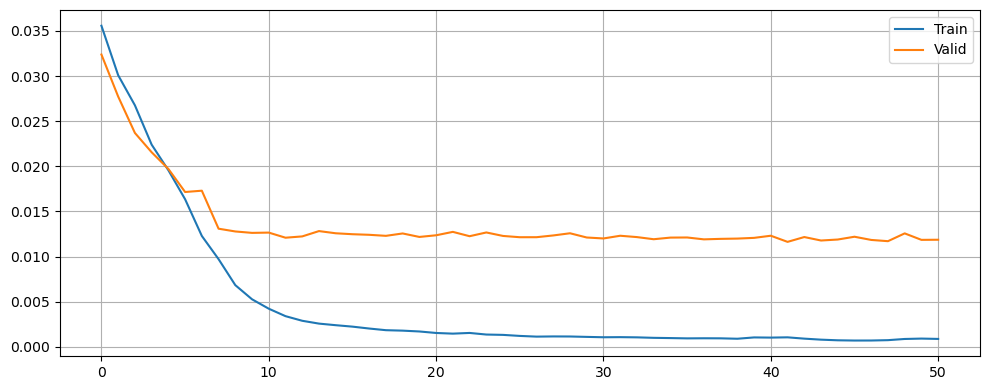

In [5]:
losses = pd.read_csv('data/fno_losses.csv')
plot_losses(losses)

In [ ]:
# u_train = fno.forward(X_train.to(device)).detach().cpu().numpy()
# u_valid = fno.forward(X_valid.to(device)).detach().cpu().numpy()
# u_test  = fno.forward(X_test.to(device)).detach().cpu().numpy()
# print('u_train: {} | u_valid: {} | u_test: {}'.format(u_train.shape, u_valid.shape, u_test.shape))
# np.savez('data/u_data.npz', u_train=u_train, u_valid=u_valid, u_test=u_test)

In [6]:
u_train = fno.forward(X_train[:10].to(device)).detach().cpu().numpy()
u_valid = fno.forward(X_valid[:10].to(device)).detach().cpu().numpy()
u_test  = fno.forward(X_test[:10].to(device)).detach().cpu().numpy()
print('u_train: {} | u_valid: {} | u_test: {}'.format(u_train.shape, u_valid.shape, u_test.shape))
np.savez('data/u_data.npz', u_train=u_train, u_valid=u_valid, u_test=u_test)

u_train: (10, 2, 64, 64, 20) | u_valid: (10, 2, 64, 64, 20) | u_test: (10, 2, 64, 64, 20)


In [7]:
xx_train = X_train[:10].detach().cpu().numpy()
xx_valid = X_valid[:10].detach().cpu().numpy()
xx_test  = X_test[:10].detach().cpu().numpy()

yy_train = y_train[:10].detach().cpu().numpy()
yy_valid = y_valid[:10].detach().cpu().numpy()
yy_test  = y_test[:10].detach().cpu().numpy()

p_train = yy_train[:,0]
s_train = yy_train[:,1]

p_valid = yy_valid[:,0]
s_valid = yy_valid[:,1]

p_test = yy_test[:,0]
s_test = yy_test[:,1]

p_train_pred = u_train[:,0]
s_train_pred = u_train[:,1]

p_valid_pred = u_valid[:,0]
s_valid_pred = u_valid[:,1]

p_test_pred = u_test[:,0]
s_test_pred = u_test[:,1]

In [51]:
ww_true = np.array([[20,20,44,44], [20,44,20,44]]).T - 1

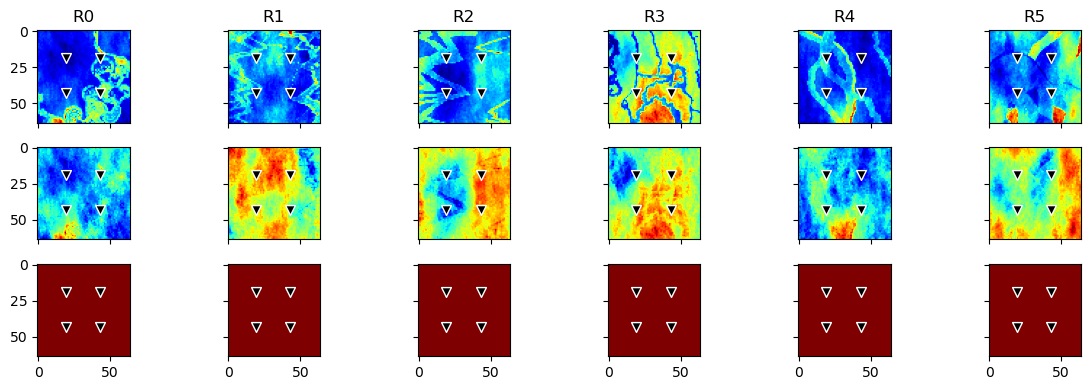

In [56]:
fig, axs = plt.subplots(3, 6, figsize=(12,4), sharex=True, sharey=True)
for i in range(3):
    for j in range(6):
        axs[i,j].imshow(X_train[j,i,...,-1], cmap='jet', vmin=0 if i==2 else None, vmax=1 if i==2 else None)
        axs[i,j].scatter(ww_true[:,1], ww_true[:,0], marker='v', color='k', edgecolor='w', s=50)
        axs[0,j].set(title='R{}'.format(j))
plt.tight_layout()
plt.show()

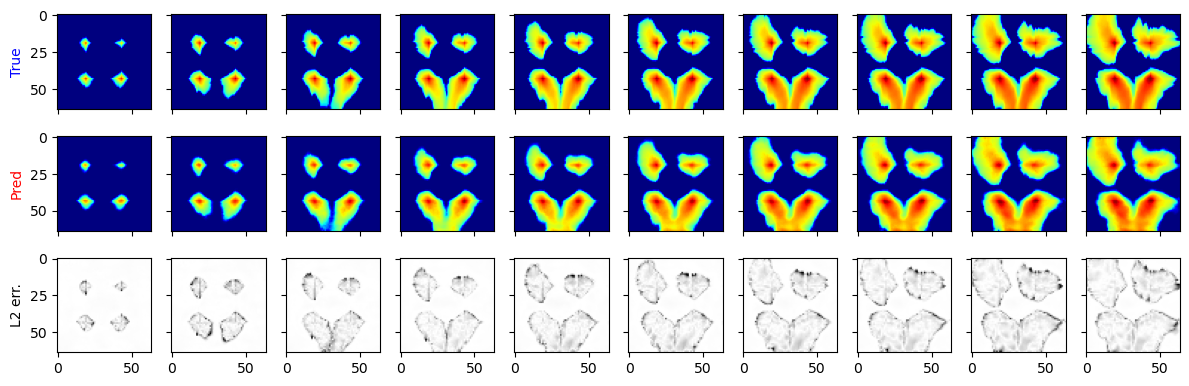

In [81]:
sample = 4
fig, axs = plt.subplots(3, 10, figsize=(12,4), sharex=True, sharey=True)
for j in range(10):
    k = j*2
    ax1, ax2, ax3 = axs[0,j], axs[1,j], axs[2,j]
    t = y_train[sample, -1, ..., k].detach().cpu().numpy()
    p = u_train[sample, -1, ..., k]
    t_, p_ = np.expand_dims(t,0), np.expand_dims(p,0)
    e = sla.norm(t_ - p_, axis=0) / sla.norm(t)
    ax1.imshow(t, cmap='jet', vmin=0, vmax=1)
    ax2.imshow(p, cmap='jet', vmin=0, vmax=1)
    ax3.imshow(e, cmap='binary')
    ax1.set_ylabel('True', color='b') if j==0 else None
    ax2.set_ylabel('Pred', color='r') if j==0 else None
    ax3.set_ylabel('L2 err.', color='k') if j==0 else None
plt.tight_layout()
plt.show()

Pressure   - train: 0.0002 | valid: 0.0024 | test: 0.0020
Saturation - train: 0.0014 | valid: 0.0225 | test: 0.0356
----------------------------------------
Pressure   - train: 0.9761 | valid: 0.7189 | test: 0.6710
Saturation - train: 0.9768 | valid: 0.6694 | test: 0.5121
----------------------------------------
Pressure   - train: 37.9886 | valid: 26.1952 | test: 27.0031
Saturation - train: 28.5793 | valid: 16.4820 | test: 14.4795
----------------------------------------
Pressure   - train: 0.9754 | valid: 0.7237 | test: 0.6786
Saturation - train: 0.9818 | valid: 0.6802 | test: 0.5692
----------------------------------------


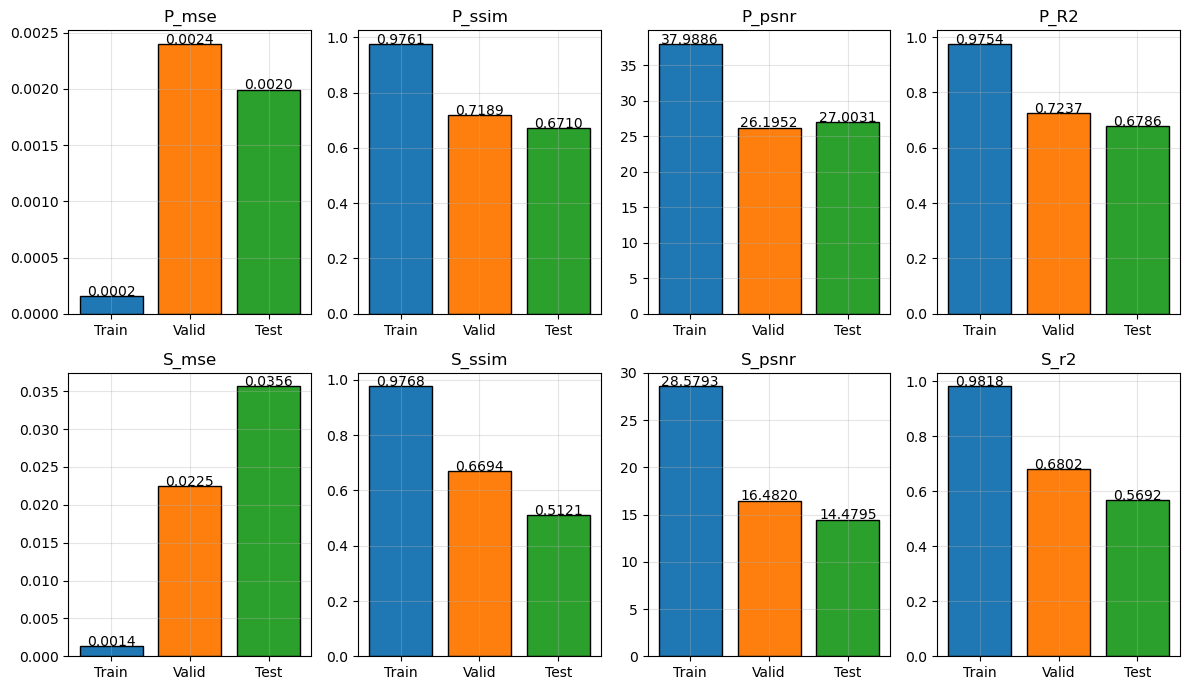

In [10]:
mse_p_train = mean_squared_error(p_train, p_train_pred)
mse_p_valid = mean_squared_error(p_valid, p_valid_pred)
mse_p_test  = mean_squared_error(p_test, p_test_pred)
print('Pressure   - train: {:.4f} | valid: {:.4f} | test: {:.4f}'.format(mse_p_train, mse_p_valid, mse_p_test))

mse_s_train = mean_squared_error(s_train, s_train_pred)
mse_s_valid = mean_squared_error(s_valid, s_valid_pred)
mse_s_test  = mean_squared_error(s_test, s_test_pred)
print('Saturation - train: {:.4f} | valid: {:.4f} | test: {:.4f}'.format(mse_s_train, mse_s_valid, mse_s_test))
print('-'*40)

ssim_p_train = structural_similarity(p_train, p_train_pred, data_range=1)
ssim_p_valid = structural_similarity(p_valid, p_valid_pred, data_range=1)
ssim_p_test  = structural_similarity(p_test, p_test_pred, data_range=1)
print('Pressure   - train: {:.4f} | valid: {:.4f} | test: {:.4f}'.format(ssim_p_train, ssim_p_valid, ssim_p_test))

ssim_s_train = structural_similarity(s_train, s_train_pred, data_range=1)
ssim_s_valid = structural_similarity(s_valid, s_valid_pred, data_range=1)
ssim_s_test  = structural_similarity(s_test, s_test_pred, data_range=1)
print('Saturation - train: {:.4f} | valid: {:.4f} | test: {:.4f}'.format(ssim_s_train, ssim_s_valid, ssim_s_test))
print('-'*40)

psnr_p_train = peak_signal_noise_ratio(p_train, p_train_pred, data_range=1)
psnr_p_valid = peak_signal_noise_ratio(p_valid, p_valid_pred, data_range=1)
psnr_p_test  = peak_signal_noise_ratio(p_test, p_test_pred, data_range=1)
print('Pressure   - train: {:.4f} | valid: {:.4f} | test: {:.4f}'.format(psnr_p_train, psnr_p_valid, psnr_p_test))

psnr_s_train = peak_signal_noise_ratio(s_train, s_train_pred, data_range=1)
psnr_s_valid = peak_signal_noise_ratio(s_valid, s_valid_pred, data_range=1)
psnr_s_test  = peak_signal_noise_ratio(s_test, s_test_pred, data_range=1)
print('Saturation - train: {:.4f} | valid: {:.4f} | test: {:.4f}'.format(psnr_s_train, psnr_s_valid, psnr_s_test))
print('-'*40)

r2_p_train = np.mean([r2_score(p_train[i].flatten(), p_train_pred[i].flatten()) for i in range(10)])
r2_p_valid = np.mean([r2_score(p_valid[i].flatten(), p_valid_pred[i].flatten()) for i in range(10)])
r2_p_test  = np.mean([r2_score(p_test[i].flatten(), p_test_pred[i].flatten()) for i in range(10)])
print('Pressure   - train: {:.4f} | valid: {:.4f} | test: {:.4f}'.format(r2_p_train, r2_p_valid, r2_p_test))

r2_s_train = np.mean([r2_score(s_train[i].flatten(), s_train_pred[i].flatten()) for i in range(10)])
r2_s_valid = np.mean([r2_score(s_valid[i].flatten(), s_valid_pred[i].flatten()) for i in range(10)])
r2_s_test  = np.mean([r2_score(s_test[i].flatten(), s_test_pred[i].flatten()) for i in range(10)])
print('Saturation - train: {:.4f} | valid: {:.4f} | test: {:.4f}'.format(r2_s_train, r2_s_valid, r2_s_test))
print('-'*40)

metrics = pd.DataFrame({'P_mse': [mse_p_train, mse_p_valid, mse_p_test], 'S_mse': [mse_s_train, mse_s_valid, mse_s_test],
                        'P_ssim': [ssim_p_train, ssim_p_valid, ssim_p_test], 'S_ssim': [ssim_s_train, ssim_s_valid, ssim_s_test],
                        'P_psnr': [psnr_p_train, psnr_p_valid, psnr_p_test], 'S_psnr': [psnr_s_train, psnr_s_valid, psnr_s_test],
                        'P_R2': [r2_p_train, r2_p_valid, r2_p_test], 'S_r2': [r2_s_train, r2_s_valid, r2_s_test]},
                        index=['Train', 'Valid', 'Test'])

fig, axs = plt.subplots(2, 4, figsize=(12,7))
for j in range(4):
    ax = axs[0,j]
    b1 = ax.bar(metrics.index, metrics.iloc[:,j*2], color=['C0','C1','C2'], edgecolor='k', label=metrics.index)
    ax.set(title=metrics.columns[j*2])
    ax.bar_label(b1, fmt='%.4f', padding=-2)
    ax2 = axs[1,j]
    b2 = ax2.bar(metrics.index, metrics.iloc[:,j*2+1], color=['C0','C1','C2'], edgecolor='k', label=metrics.index)
    ax2.set(title=metrics.columns[j*2+1])
    ax2.bar_label(b2, fmt='%.4f', padding=-2)
    for i in range(2):
        axs[i,j].grid(True, which='both', alpha=0.33)
plt.tight_layout()
plt.show()

***
### Ensemble Model Calibration

In [11]:
def forward_model(m_ensemble, **kwargs):
    n_ensemble = kwargs.get('n_ensemble', 10)
    c_assimilation = kwargs.get('c_assimilation', 1)
    t_assimilation = kwargs.get('t_assimilation', 10)
    def expand_repeat(x,a,t):
        return np.repeat(np.expand_dims(x,a), t, a)
    m = expand_repeat(m_ensemble.reshape(n_ensemble,2,NX,NY), a=-1, t=20) # (b,2,64,64,20)
    t = times_norm[:n_ensemble]                                           # (b,1,64,64,20)
    x = torch.tensor(np.concatenate([m, t], 1), dtype=torch.float32)      # (b,3,64,64,20)
    u = fno.forward(x.to(device)).detach().cpu().numpy()                  # (b,2,64,64,20)
    d = u[:,c_assimilation,...,t_assimilation].reshape(n_ensemble, -1)    # (b,4096)
    return d

In [12]:
def spatial_data_assimilation(truth_sample:int, t_assimilation:int, c_assimilation:int=1, 
                              n_ensemble:int=10, ens_start:int=400, ens_step=2,
                              m_ensemble=None,
                              n_assimilations:int=4, 
                              cov_obs_inflation_geo=1.2,
                              cov_obs_inflation_factors=1.1):
    
    print('Assimilation year: {:.2f}'.format(timesteps[t_assimilation]))
    print('Assimilation channel: {} ({})'.format(c_assimilation, 'Saturation' if c_assimilation==1 else 'Pressure'))

    ww_true = np.array([[20,20,44,44], [20,44,20,44]]).T - 1
    print('Wells Truth: {}'.format(ww_true.shape))

    mm_true = np.expand_dims(features[truth_sample,:2,...,t_assimilation], (0,-1)).squeeze()
    dd_true = np.expand_dims(targets[truth_sample,c_assimilation,...,t_assimilation], (0,1,-1)).squeeze()
    dd_obs  = dd_true.flatten()
    print('Ground Truth - Model: {} | Data: {}, Obs: {}'.format(mm_true.shape, dd_true.shape, dd_obs.shape))

    ens_idx = np.arange(ens_start, ens_start+n_ensemble*ens_step, step=ens_step)
    if m_ensemble is None:
        m_ensemble = np.expand_dims(features[ens_idx,:2,...,t_assimilation], -1).squeeze().reshape(n_ensemble, -1)
    print('Model Ensemble: {}'.format(m_ensemble.shape))

    cov_obs = np.diag([dd_obs.std()] * dd_obs.shape[0])
    print('Covariance Observations - Cdd: {}'.format(cov_obs.shape))
    print('-'*50)

    cov_obs_inflation_factors = [cov_obs_inflation_factors]
    for l in range(1, n_assimilations):
        cov_obs_inflation_factors.append(cov_obs_inflation_factors[l-1] / cov_obs_inflation_geo)
    scaling_factor = np.sum(1 / np.array(cov_obs_inflation_factors))
    cov_obs_inflation_factors = [ alpha * scaling_factor for alpha in cov_obs_inflation_factors]
    cov_mm_inflation_factors  = [cov_obs_inflation_geo] * n_assimilations

    solver = ESMDA(
        obs                      = dd_obs,
        m_init                   = m_ensemble,
        m_bounds                 = np.concatenate([np.zeros(shape=(2*NX*NY,1)), np.ones(shape=(2*NX*NY,1))], -1),
        cov_obs                  = cov_obs,
        forward_model            = forward_model,
        forward_model_kwargs     = dict(n_ensemble=n_ensemble, 
                                        c_assimilation=c_assimilation, 
                                        t_assimilation=t_assimilation),
        n_assimilations           = n_assimilations,
        cov_obs_inflation_factors = cov_obs_inflation_factors,
        cov_mm_inflation_factors  = cov_mm_inflation_factors,
        save_ensembles_history    = True
    )
    start = time(); solver.solve(); end=time()-start
    print('Elapsed time: {:.2f} minutes'.format(end/60))
    print('-'*50+'\n')

    return solver, (mm_true, ww_true, dd_true, m_ensemble, dd_obs)

In [13]:
truth_sample   = 82
n_ensemble     = 10
t_assimilation = 9 #5->3, 9->5, 14->7.5

solver, vv = spatial_data_assimilation(truth_sample=truth_sample, 
                                       t_assimilation=t_assimilation, 
                                       c_assimilation=1,
                                       n_ensemble=n_ensemble)
mm_true, ww_true, dd_true, m_ensemble, dd_obs = vv

Assimilation year: 5.00
Assimilation channel: 1 (Saturation)
Wells Truth: (4, 2)
Ground Truth - Model: (2, 64, 64) | Data: (64, 64), Obs: (4096,)
Model Ensemble: (10, 8192)
Covariance Observations - Cdd: (4096, 4096)
--------------------------------------------------
Assimilation # 1
Assimilation # 2
Assimilation # 3
Assimilation # 4
Elapsed time: 1.35 minutes
--------------------------------------------------



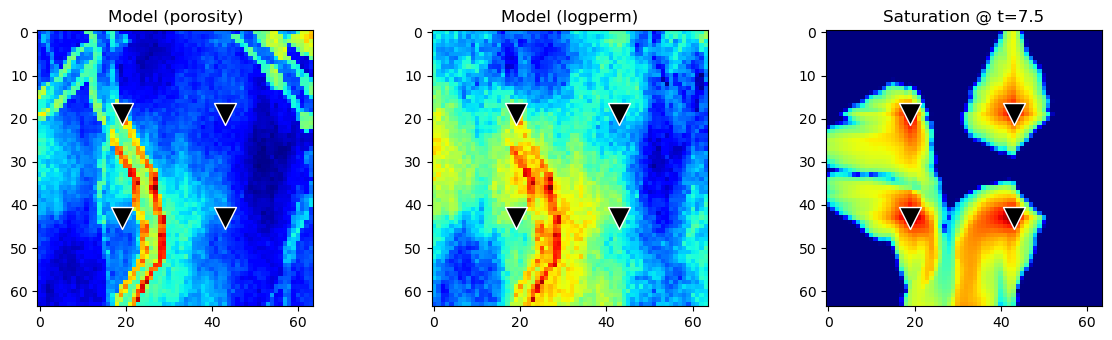

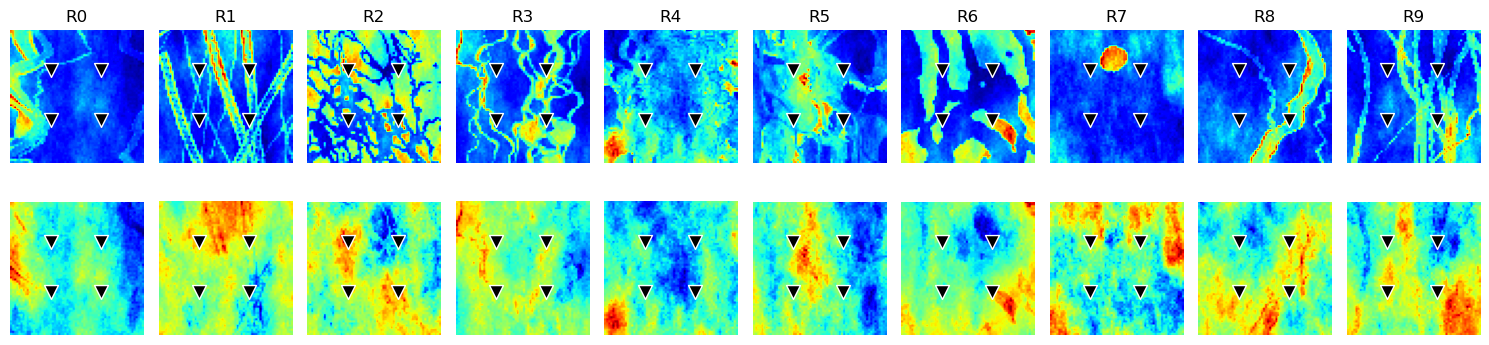

In [14]:
plt.figure(figsize=(12,3.5))
plt.subplot(131)
plt.imshow(mm_true[0].squeeze(), 'jet')
plt.scatter(ww_true[:,1], ww_true[:,0], c='k', s=250, marker='v', edgecolor='w')
plt.title('Model (porosity)')
plt.subplot(132)
plt.imshow(mm_true[1].squeeze(), 'jet')
plt.scatter(ww_true[:,1], ww_true[:,0], c='k', s=250, marker='v', edgecolor='w')
plt.title('Model (logperm)')
plt.subplot(133)
plt.imshow(dd_true.squeeze(), 'jet')
plt.scatter(ww_true[:,1], ww_true[:,0], c='k', s=250, marker='v', edgecolor='w')
plt.title('Saturation @ t={:.1f}'.format(timesteps[14]))
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(2, n_ensemble, figsize=(15,4), sharex=True, sharey=True)
for i in range(2):
    for j in range(n_ensemble):
        ax = axs[i,j]
        x = m_ensemble.reshape(n_ensemble,2,NX,NY)[j,i]
        im = ax.imshow(x, cmap='jet')
        ax.scatter(ww_true[:,1], ww_true[:,0], c='k', s=100, marker='v', edgecolor='w')
        ax.axis('off')
        ax.set(title='R{}'.format(j)) if i==0 else None
plt.tight_layout()
plt.show()

In [15]:
m_prior_mean     = np.mean(m_ensemble.reshape(n_ensemble, 2, NX, NY)[:,0],  axis=0)
m_prior_stdv     = np.std(m_ensemble.reshape(n_ensemble, 2, NX, NY)[:,0],   axis=0)
m_posterior_mean = np.mean(solver.m_history[-1].reshape(n_ensemble, 2, NX, NY)[:,0], axis=0)
m_posterior_stdv = np.std(solver.m_history[-1].reshape(n_ensemble, 2, NX, NY)[:,0],  axis=0)

d_prior_mean     = np.mean(solver.d_history[0].reshape(n_ensemble,NX,NY),   axis=0)
d_prior_stdv     = np.std(solver.d_history[0].reshape(n_ensemble,NX,NY),    axis=0)
d_posterior_mean = np.mean(solver.d_history[-1].reshape(n_ensemble,NX,NY),  axis=0)
d_posterior_stdv = np.std(solver.d_history[-1].reshape(n_ensemble,NX,NY),   axis=0)

data = [[m_prior_mean, m_prior_stdv, d_prior_mean, d_prior_stdv],
        [m_posterior_mean, m_posterior_stdv, d_posterior_mean, d_posterior_stdv]]
labels = [['Mean(M_prior)', 'StDev(M_prior)', 'Mean(D_prior)', 'StDev(D_prior)'],
          ['Mean(M_posterior)', 'StDev(M_posterior)', 'Mean(D_posterior)', 'StDev(D_posterior)']]

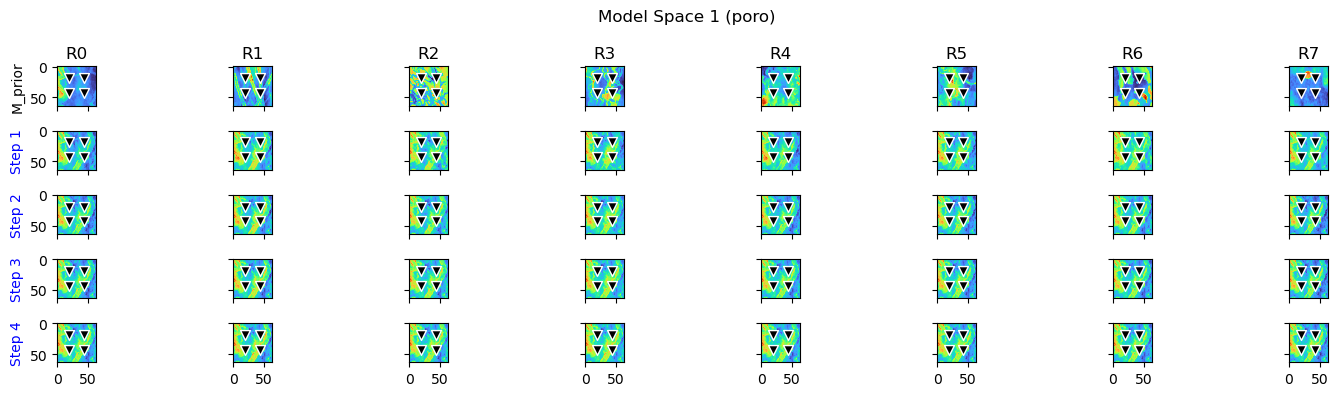

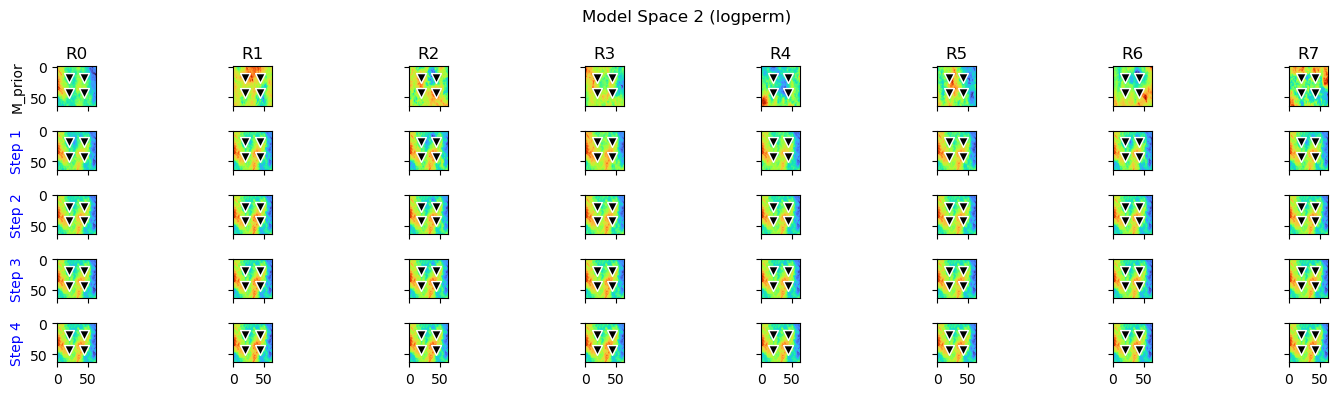

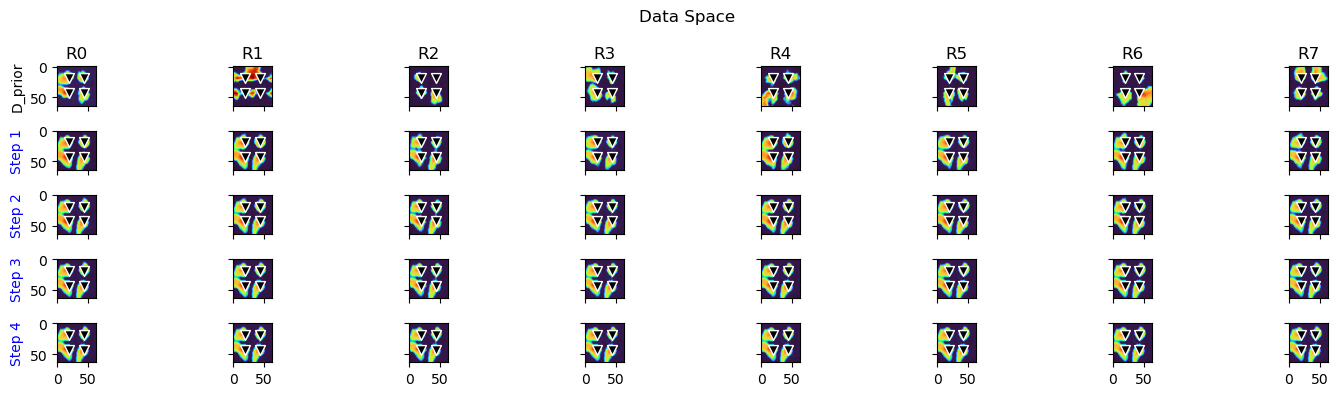

In [83]:
na = solver.n_assimilations
m_labels = ['M_prior'] + ['Step {}'.format(k+1) for k in range(na)]
d_labels = ['D_prior'] + ['Step {}'.format(k+1) for k in range(na)]
hues = ['k'] + ['b']*na + ['r']
cmap, vmin, vmax = 'turbo', None, None
n_show = 8

fig, axs = plt.subplots(na+1, np.min([n_ensemble, n_show]), figsize=(15,4), sharex=True, sharey=True)
for i in range(na+1):
    for j in range(np.min([n_ensemble, n_show])):
        ax = axs[i,j]
        ax.set_title('R{}'.format(j)) if i==0 else None
        ax.imshow(solver.m_history[i][j].reshape(2,NX,NY)[0], cmap=cmap, vmin=vmin, vmax=vmax)
        ax.scatter(ww_true[:,1], ww_true[:,0], c='k', s=50, marker='v', edgecolor='w')
        ax.set_ylabel(m_labels[i], color=hues[i]) if j==0 else None
fig.suptitle('Model Space 1 (poro)')
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(na+1, np.min([n_ensemble, n_show]), figsize=(15,4), sharex=True, sharey=True)
for i in range(na+1):
    for j in range(np.min([n_ensemble, n_show])):
        ax = axs[i,j]
        ax.set_title('R{}'.format(j)) if i==0 else None
        ax.imshow(solver.m_history[i][j].reshape(2,NX,NY)[1], cmap=cmap, vmin=vmin, vmax=vmax)
        ax.scatter(ww_true[:,1], ww_true[:,0], c='k', s=50, marker='v', edgecolor='w')
        ax.set_ylabel(m_labels[i], color=hues[i]) if j==0 else None
fig.suptitle('Model Space 2 (logperm)')
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(na+1, np.min([n_ensemble, n_show]), figsize=(15,4), sharex=True, sharey=True)
for i in range(na+1):
    for j in range(np.min([n_ensemble, n_show])):
        ax = axs[i,j]
        ax.set_title('R{}'.format(j)) if i==0 else None
        ax.imshow(solver.d_history[i][j].reshape(NX,NY), cmap=cmap, vmin=vmin, vmax=vmax)
        ax.scatter(ww_true[:,1], ww_true[:,0], c='k', s=50, marker='v', edgecolor='w')
        ax.set_ylabel(d_labels[i], color=hues[i]) if j==0 else None
fig.suptitle('Data Space')
plt.tight_layout()
plt.show()

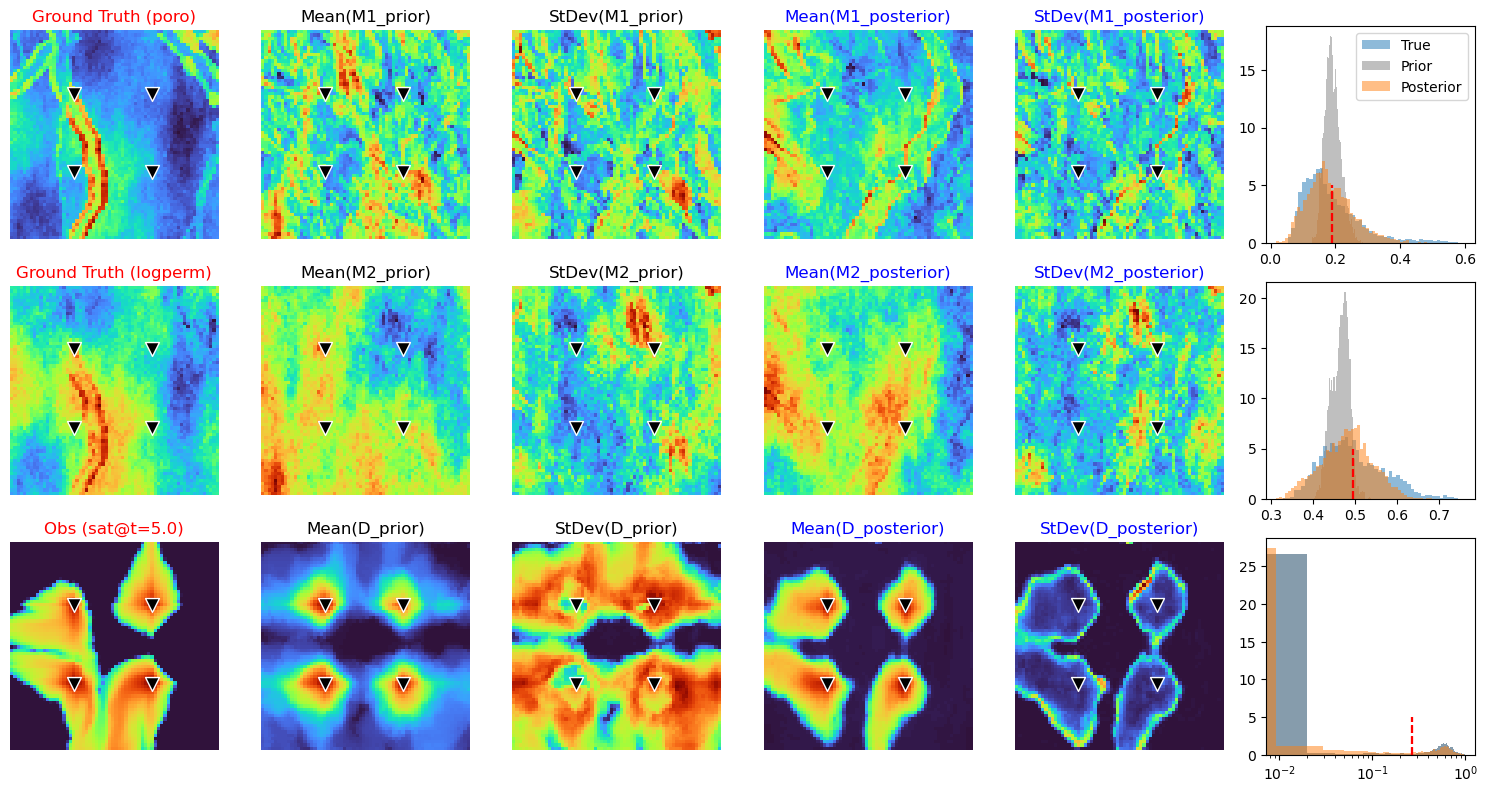

In [94]:
p_prior_mean     = np.mean(m_ensemble.reshape(n_ensemble, 2, NX, NY)[:,0],  axis=0)
p_prior_stdv     = np.std(m_ensemble.reshape(n_ensemble, 2, NX, NY)[:,0],   axis=0)
p_posterior_mean = np.mean(solver.m_history[-1].reshape(n_ensemble, 2, NX, NY)[:,0], axis=0)
p_posterior_stdv = np.std(solver.m_history[-1].reshape(n_ensemble, 2, NX, NY)[:,0],  axis=0)

k_prior_mean     = np.mean(m_ensemble.reshape(n_ensemble, 2, NX, NY)[:,1],  axis=0)
k_prior_stdv     = np.std(m_ensemble.reshape(n_ensemble, 2, NX, NY)[:,1],   axis=0)
k_posterior_mean = np.mean(solver.m_history[-1].reshape(n_ensemble, 2, NX, NY)[:,1], axis=0)
k_posterior_stdv = np.std(solver.m_history[-1].reshape(n_ensemble, 2, NX, NY)[:,1],  axis=0)

d_prior_mean     = np.mean(solver.d_history[0].reshape(n_ensemble,NX,NY),   axis=0)
d_prior_stdv     = np.std(solver.d_history[0].reshape(n_ensemble,NX,NY),    axis=0)
d_posterior_mean = np.mean(solver.d_history[-1].reshape(n_ensemble,NX,NY),  axis=0)
d_posterior_stdv = np.std(solver.d_history[-1].reshape(n_ensemble,NX,NY),   axis=0)

data = [[p_prior_mean, p_prior_stdv, p_posterior_mean, p_posterior_stdv],
        [k_prior_mean, k_prior_stdv, k_posterior_mean, k_posterior_stdv],
        [d_prior_mean, d_prior_stdv, d_posterior_mean, d_posterior_stdv]]
labels = [['Mean(M1_prior)', 'StDev(M1_prior)', 'Mean(M1_posterior)', 'StDev(M1_posterior)'],
          ['Mean(M2_prior)', 'StDev(M2_prior)', 'Mean(M2_posterior)', 'StDev(M2_posterior)'],
          ['Mean(D_prior)', 'StDev(D_prior)', 'Mean(D_posterior)', 'StDev(D_posterior)']]

hh_true = [mm_true[0].flatten(), mm_true[1].flatten(), dd_true.flatten()]
hh_prior = [m_ensemble.reshape(n_ensemble,2,NX,NY)[:,0].mean(0).flatten(),
            m_ensemble.reshape(n_ensemble,2,NX,NY)[:,1].mean(0).flatten(),
            dd_obs]
hh_posterior = [solver.m_history[-1].reshape(n_ensemble,2,NX,NY)[:,0].mean(0).flatten(),
                solver.m_history[-1].reshape(n_ensemble,2,NX,NY)[:,1].mean(0).flatten(),
                solver.d_history[-1].mean(0).flatten()]
hh = [hh_true, hh_prior, hh_posterior]

cmap, vmin, vmax = 'turbo', None, None
fig, axs = plt.subplots(3, 6, figsize=(15,8))
for i in range(3):
    for j in range(1,5):
        ax = axs[i,j]
        k = j-1
        im = ax.imshow(data[i][k], cmap=cmap, vmin=vmin, vmax=vmax)
        ax.scatter(ww_true[:,1], ww_true[:,0], c='k', s=100, marker='v', edgecolor='w')
        ax.set_title(labels[i][k], c='b' if j>2 else 'k')
        ax.axis('off')
    ax1 = axs[i,0]
    im1 = ax1.imshow([mm_true[0], mm_true[1], dd_true][i], cmap=cmap, vmin=vmin, vmax=vmax)
    ax1.set_title(['Ground Truth (poro)', 'Ground Truth (logperm)', 
                  'Obs (sat@t={:.1f})'.format(timesteps[t_assimilation])][i], c='r')
    ax1.scatter(ww_true[:,1], ww_true[:,0], c='k', s=100, marker='v', edgecolor='w')
    ax1.axis('off')

    ax6 = axs[i,5]
    labs = ['True', 'Prior', 'Posterior']
    for k in range(3):
        ax6.hist(hh[k][i], bins=50, alpha=0.5, label=labs[k], density=True, color=['C0','gray','C1'][k])
        ax6.vlines([mm_true[0], mm_true[1], dd_obs][i].flatten().mean(), 0, 5, color='r', ls='--')
    ax6.legend() if i==0 else None
    ax6.set_xscale('log') if i==2 else None

plt.tight_layout()
plt.show()

***
# END